# The Three-Body Problem

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
plt.style.use('seaborn-v0_8')

## Task 1: Setting the Baseline
### Task 1.1 Data Preparation and Validation Pipeline

In [4]:
# Read in the data
df = pd.read_csv("data/X_train.csv")

# Function to return the i-th trajectory
def get_traj(df, i):
    return df[257 * i:257 * (i + 1)]

# remove duplicte trajectory
# L = 257
# n_traj = len(df) // L
# df = df.drop(df.filter(regex="^(Id|v_)").columns, axis=1)
# df["traj_id"] = np.repeat(np.arange(n_traj), L)
# deduped = df.groupby("traj_id")[["x_1","y_1","x_2","y_2","x_3","y_3"]].apply(
#     lambda g: hashlib.md5(g.to_numpy().tobytes()).hexdigest()
# ).reset_index(name="hash")
# unique_ids = deduped.drop_duplicates("hash")["traj_id"].values
# clean_df = df[df.traj_id.isin(unique_ids)].drop(columns="traj_id").reset_index(drop=True)
# print((len(df) - len(clean_df))/L, "duplicate trajectory removed" )

# df = clean_df

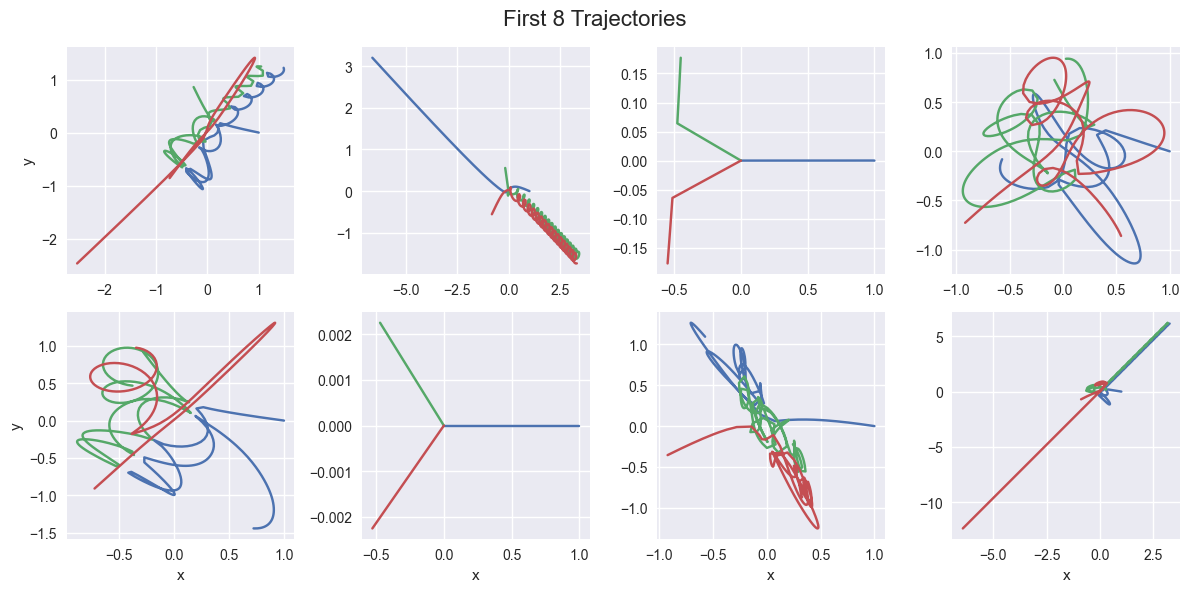

In [5]:
# Plotting the first 8 trajectories
fig, axes = plt.subplots(2, 4, figsize=(12, 6))


axes = axes.flatten()


for i, ax in enumerate(axes):
    traj = get_traj(df, i)
    ax.plot(traj["x_1"], traj["y_1"])
    ax.plot(traj["x_2"], traj["y_2"])
    ax.plot(traj["x_3"], traj["y_3"])
    if i in [0, 4]:
        ax.set_ylabel("y")
    if i >= 4:
        ax.set_xlabel("x")

fig.suptitle("First 8 Trajectories", fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
# Function to split the dataset into train and validation set
def train_validation_split(df, splits=[0.8, 0.2]):
    n_traj = int(len(df) / 257)
    n_train = int(n_traj * splits[0]) * 257
    
    trainset = df[:n_train]
    valset = df[n_train:]

    return trainset, valset

### Task 1.3 Learn the baseline model

In [7]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

trainset, valset = train_validation_split(df, [0.8, 0.2])

L = 257
POS = ["x_1","y_1","x_2","y_2","x_3","y_3"]

def build_init2t_XY(frame, L=L):
  
    n_traj = len(frame)//L
    X_list, Y_list = [], []

    for i in range(n_traj):
        blk = get_traj(frame, i)
        tvec = blk["t"].to_numpy()
        init_pos = blk.iloc[0][POS].to_numpy()  # positions at t=0
        Xb = np.column_stack([tvec, np.tile(init_pos, (len(blk), 1))])
        Yb = blk[POS].to_numpy()
        X_list.append(Xb)
        Y_list.append(Yb)

    X = np.vstack(X_list)
    Y = np.vstack(Y_list)
    return X, Y

def build_init2t_X(frame, L=L):

    n_traj = len(frame)//L
    X_list = []
    POS_test = ["x0_1","y0_1","x0_2","y0_2","x0_3","y0_3"]
    for i in range(n_traj):
        blk = get_traj(frame, i)
        tvec = blk["t"].to_numpy()
        init_pos = blk.iloc[0][POS_test].to_numpy()
        Xb = np.column_stack([tvec, np.tile(init_pos, (len(blk), 1))])
        X_list.append(Xb)
    return np.vstack(X_list)


X_train, Y_train = build_init2t_XY(trainset, L=L)
X_val, Y_val = build_init2t_XY(valset, L=L)



Validation RMSE: 1.457


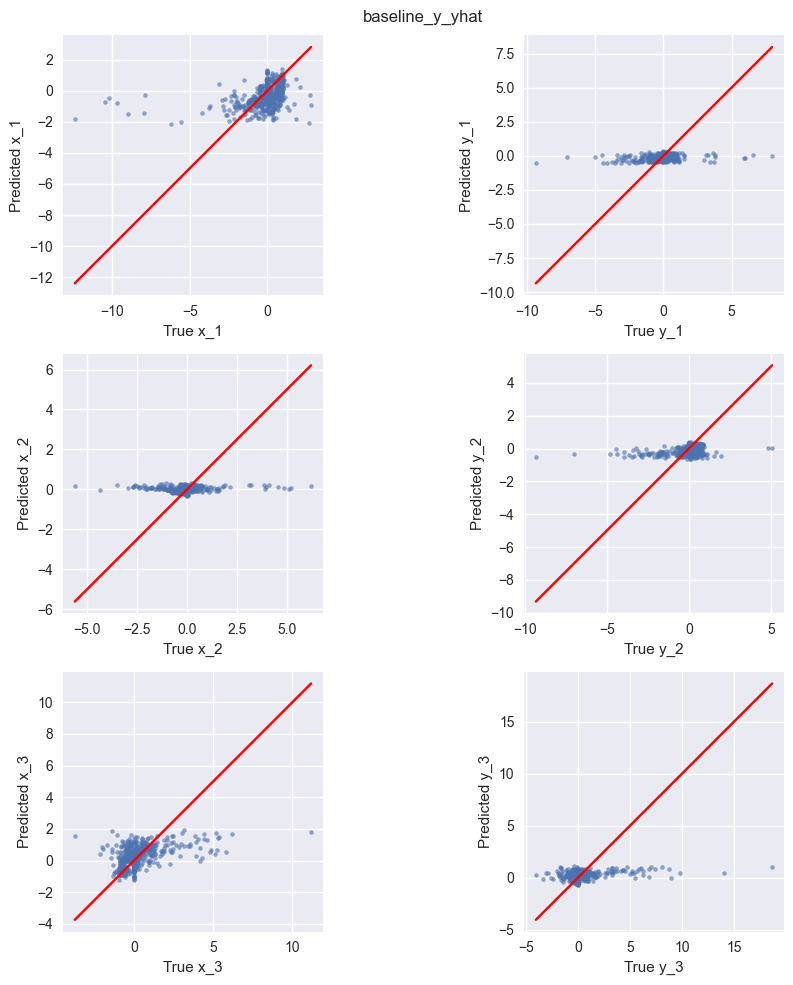

Wrote baseline-model.csv


In [8]:
# pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lin", LinearRegression())
])
pipe.fit(X_train, Y_train)


Y_val_pred = pipe.predict(X_val)
rmse = root_mean_squared_error(Y_val, Y_val_pred)
print(f"Validation RMSE: {rmse:.3f}")

def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i], s=8, alpha=0.6)
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.suptitle(plot_title)
    plt.tight_layout()
    plt.savefig(plot_title+'.pdf')
    plt.show()

plot_y_yhat(Y_val, Y_val_pred, plot_title="baseline_y_yhat")

# Kaggle submission
X_all, Y_all = np.vstack([X_train, X_val]), np.vstack([Y_train, Y_val])
pipe.fit(X_all, Y_all)


X_kaggle = pd.read_csv("data/X_test.csv")
# X_kaggle.info(verbose=True)
X_kaggle_feat = build_init2t_X(X_kaggle, L=L)

Y_kaggle_pred = pipe.predict(X_kaggle_feat)
Id = np.arange(len(Y_kaggle_pred), dtype=int)

submission = pd.DataFrame(Y_kaggle_pred, columns=POS)
submission.insert(0, "Id", np.arange(len(submission), dtype=np.int64))

submission.to_csv("baseline-model.csv", index=False)
print("Wrote baseline-model.csv")

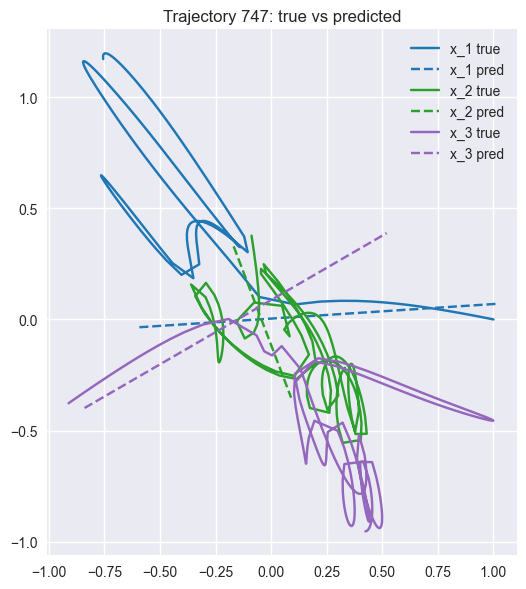

In [9]:
def get_traj_block(A, i, L=L):

    return A[i*L:(i+1)*L, :]

n_traj = len(Y_val) // L
k = np.random.randint(n_traj)  


true = get_traj_block(Y_val, k, L)
pred = get_traj_block(Y_val_pred, k, L)

names = ['x_1','y_1','x_2','y_2','x_3','y_3']

colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b']

plt.figure(figsize=(6,6))
for b, (ix, iy) in enumerate([(0,1), (2,3), (4,5)], start=1):
    plt.plot(true[:, ix], true[:, iy], label=f"{names[ix]} true", color=colors[ix])
    plt.plot(pred[:, ix], pred[:, iy], '--', label=f"{names[ix]} pred", color=colors[ix])
plt.gca().set_aspect('equal', 'box')
plt.legend()
plt.title(f"Trajectory {k}: true vs predicted")
plt.tight_layout()
plt.show()

## Task 2: Nonlinear models on the data - the Polynomial model

In [10]:
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import root_mean_squared_error

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.decomposition import PCA

def _make_regressor(regressor):
    key = str(regressor).lower()
    if key == "linear":
        return LinearRegression()
    if key == "ridgecv":
   
        return RidgeCV(alphas=np.logspace(-6, 3, 20), cv=5, scoring="neg_mean_squared_error")
    else:
        return LinearRegression()


def validate_poly_regression(X_train, y_train, X_val, y_val,
                             regressor=None, degrees=range(1, 15), max_features=None):

    best_rmse = np.inf
    best_model = None

    p = X_train.shape[1]

    for d in degrees:
        steps = []
        poly = PolynomialFeatures(degree=d, include_bias=False)
        steps.append(("poly", poly))
        steps.append(("scaler", StandardScaler()))

        if max_features is not None:
            steps.append(("pca", PCA(n_components=max_features)))

        reg = _make_regressor(regressor)
        steps.append(("reg", reg))
        pipe = Pipeline(steps)

 
        pipe.fit(X_train, y_train)

        n_out = pipe.named_steps["poly"].n_output_features_
        print(f"[degree={d}] Polynomial features: {n_out}")

        
        y_pred = pipe.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        print(f"[degree={d}] RMSE: {rmse:.6f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_model = pipe

    print(f"\nBest degree = {best_model.named_steps['poly'].degree} with RMSE = {best_rmse:.6f}")
    return best_model, best_rmse

def subsample(X, Y, frac, start_frac=0.0):
    n = len(X)
    k = int(frac * n) - int(frac * n) % 257
    s = int(start_frac * n) - int(start_frac * n) % 257
    return X[s:s+k], Y[s:s+k]

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

def run_degree_stability_tests(X_train, y_train, X_val, y_val,
                               regressor="ridgecv",
                               degrees=range(1, 4),
                               n_runs=10, sample_frac=0.1,
                               max_features=None, plot_path="degree_distribution.pdf"):
    chosen = []

    for r in range(n_runs):
        Xs, Ys = subsample(X_train, y_train, frac=sample_frac, start_frac=r*sample_frac)
        model, rmse = validate_poly_regression(
            Xs, Ys, X_val, y_val,
            regressor=regressor, degrees=degrees, max_features=max_features
        )
        chosen.append(model.named_steps["poly"].degree)
        print(f"[Run {r+1}/{n_runs}] picked degree {chosen[-1]} (RMSE={rmse:.5f})")


    counts = Counter(chosen)
    print("\nSelected degrees counts:", dict(counts))

    plt.figure(figsize=(7,4))
    xs = sorted(counts.keys())
    ys = [counts[x] for x in xs]
    plt.bar(xs, ys)
    plt.xlabel("Selected polynomial degree")
    plt.ylabel("Frequency (out of %d)" % n_runs)
    plt.title("Distribution of Selected Degrees")
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()

    # Best degree from stability (mode)
    best_degree = max(counts.items(), key=lambda kv: (kv[1], -kv[0]))[0]
    print(f"Best (modal) degree over {n_runs} runs: {best_degree}")
    return chosen, best_degree


[Baseline] Val RMSE: 1.457249


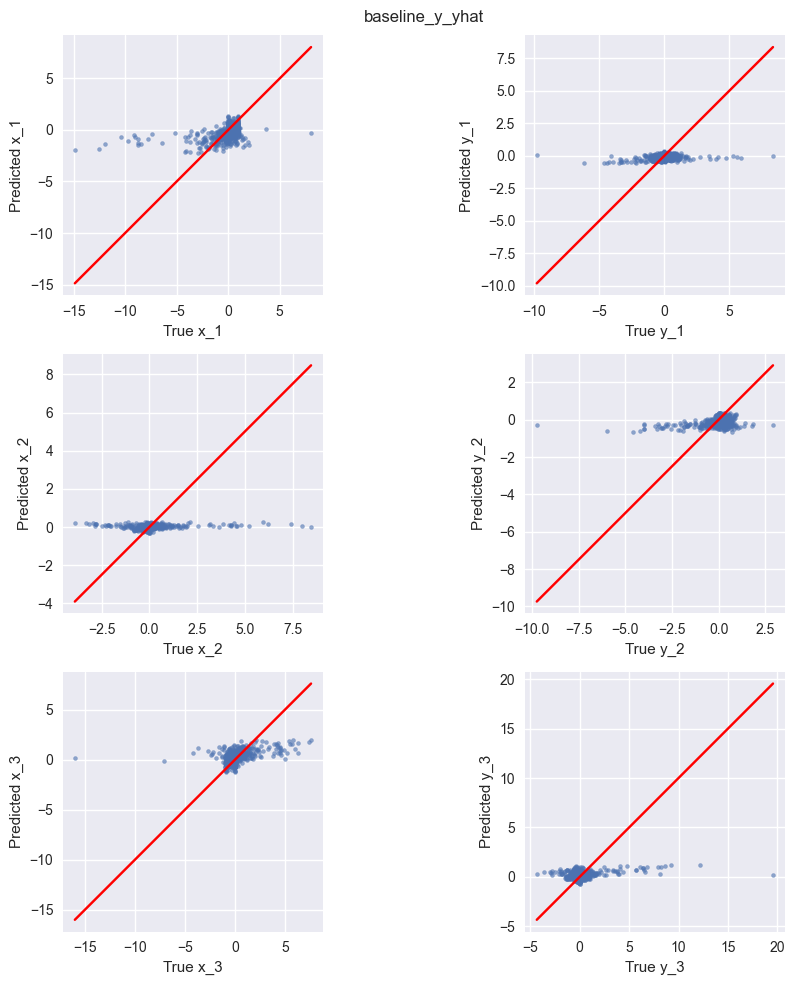

[degree=1] Polynomial features: 7
[degree=1] RMSE: 1.460150
[degree=2] Polynomial features: 35
[degree=2] RMSE: 1.429123
[degree=3] Polynomial features: 119
[degree=3] RMSE: 1.394423
[degree=4] Polynomial features: 329
[degree=4] RMSE: 1.367366

Best degree = 4 with RMSE = 1.367366
[Run 1/4] picked degree 4 (RMSE=1.36737)
[degree=1] Polynomial features: 7
[degree=1] RMSE: 1.462152
[degree=2] Polynomial features: 35
[degree=2] RMSE: 1.432904
[degree=3] Polynomial features: 119
[degree=3] RMSE: 1.404858
[degree=4] Polynomial features: 329
[degree=4] RMSE: 1.394198

Best degree = 4 with RMSE = 1.394198
[Run 2/4] picked degree 4 (RMSE=1.39420)
[degree=1] Polynomial features: 7
[degree=1] RMSE: 1.464183
[degree=2] Polynomial features: 35
[degree=2] RMSE: 1.459137
[degree=3] Polynomial features: 119
[degree=3] RMSE: 1.463297
[degree=4] Polynomial features: 329
[degree=4] RMSE: 1.468875

Best degree = 2 with RMSE = 1.459137
[Run 3/4] picked degree 2 (RMSE=1.45914)
[degree=1] Polynomial featur

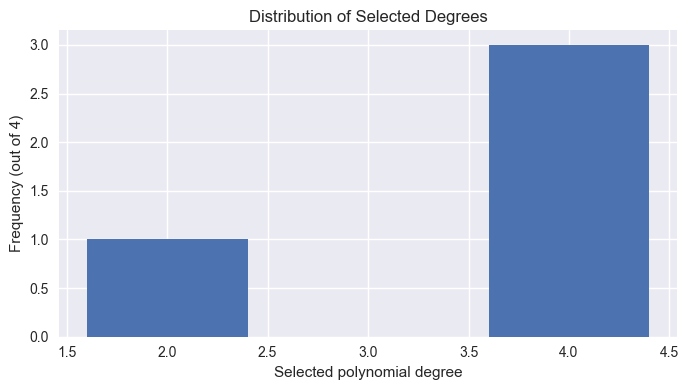

Best (modal) degree over 4 runs: 4
[Poly] Val RMSE: 1.357255


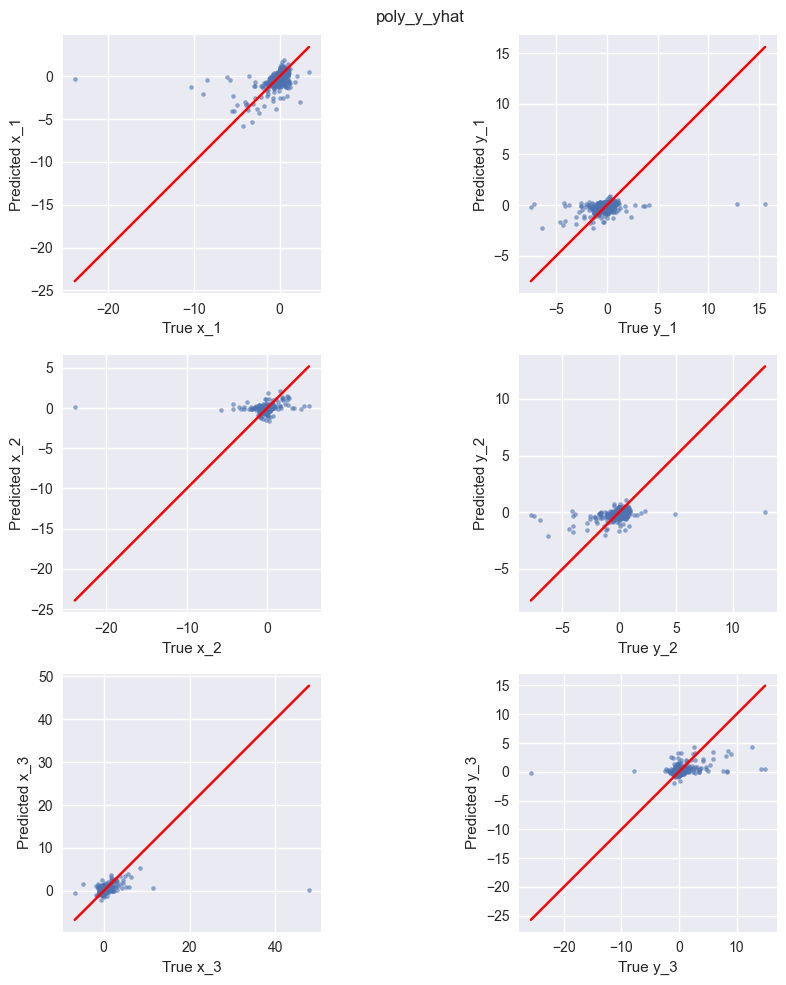

In [12]:

from sklearn.pipeline import Pipeline

X_train_sub, Y_train_sub = subsample(X_train, Y_train, frac=0.05)

baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("lin", LinearRegression())
]).fit(X_train, Y_train)

y_val_pred_base = baseline.predict(X_val)
rmse_base = root_mean_squared_error(Y_val, y_val_pred_base)
print(f"[Baseline] Val RMSE: {rmse_base:.6f}")

# y–ŷ plot 
plot_y_yhat(Y_val, y_val_pred_base, plot_title="baseline_y_yhat")

chosen_degrees, degree_mode = run_degree_stability_tests(
    X_train, Y_train, X_val, Y_val,
    regressor="ridgecv", degrees=range(1, 5),
    n_runs=4, sample_frac=0.05, max_features=None,
    plot_path="degree_distribution.pdf"
)

best_degree = degree_mode 
final_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=best_degree, include_bias=False)),
    ("scaler", StandardScaler()),
    ("reg", _make_regressor("ridgecv"))
]).fit(X_train, Y_train)


y_val_pred_poly = final_poly.predict(X_val)
rmse_poly = root_mean_squared_error(Y_val, y_val_pred_poly)
print(f"[Poly] Val RMSE: {rmse_poly:.6f}")
plot_y_yhat(Y_val, y_val_pred_poly, plot_title="poly_y_yhat")

In [14]:
# Build features for Kaggle test set
X_kaggle_df = pd.read_csv("data/X_test.csv")    
X_kaggle = build_init2t_X(X_kaggle_df, L=257)    # same feature builder as baseline

Y_kaggle_pred = final_poly.predict(X_kaggle)     # shape (rows, 6)
submission = pd.DataFrame(Y_kaggle_pred, columns=["x_1","y_1","x_2","y_2","x_3","y_3"])

submission.insert(0, "Id", np.arange(len(submission)))

submission.to_csv("polynomial_submission.csv", index=False)
print("Wrote polynomial_submission.csv")

Wrote polynomial_submission.csv


## Task 3: Feature Engineering

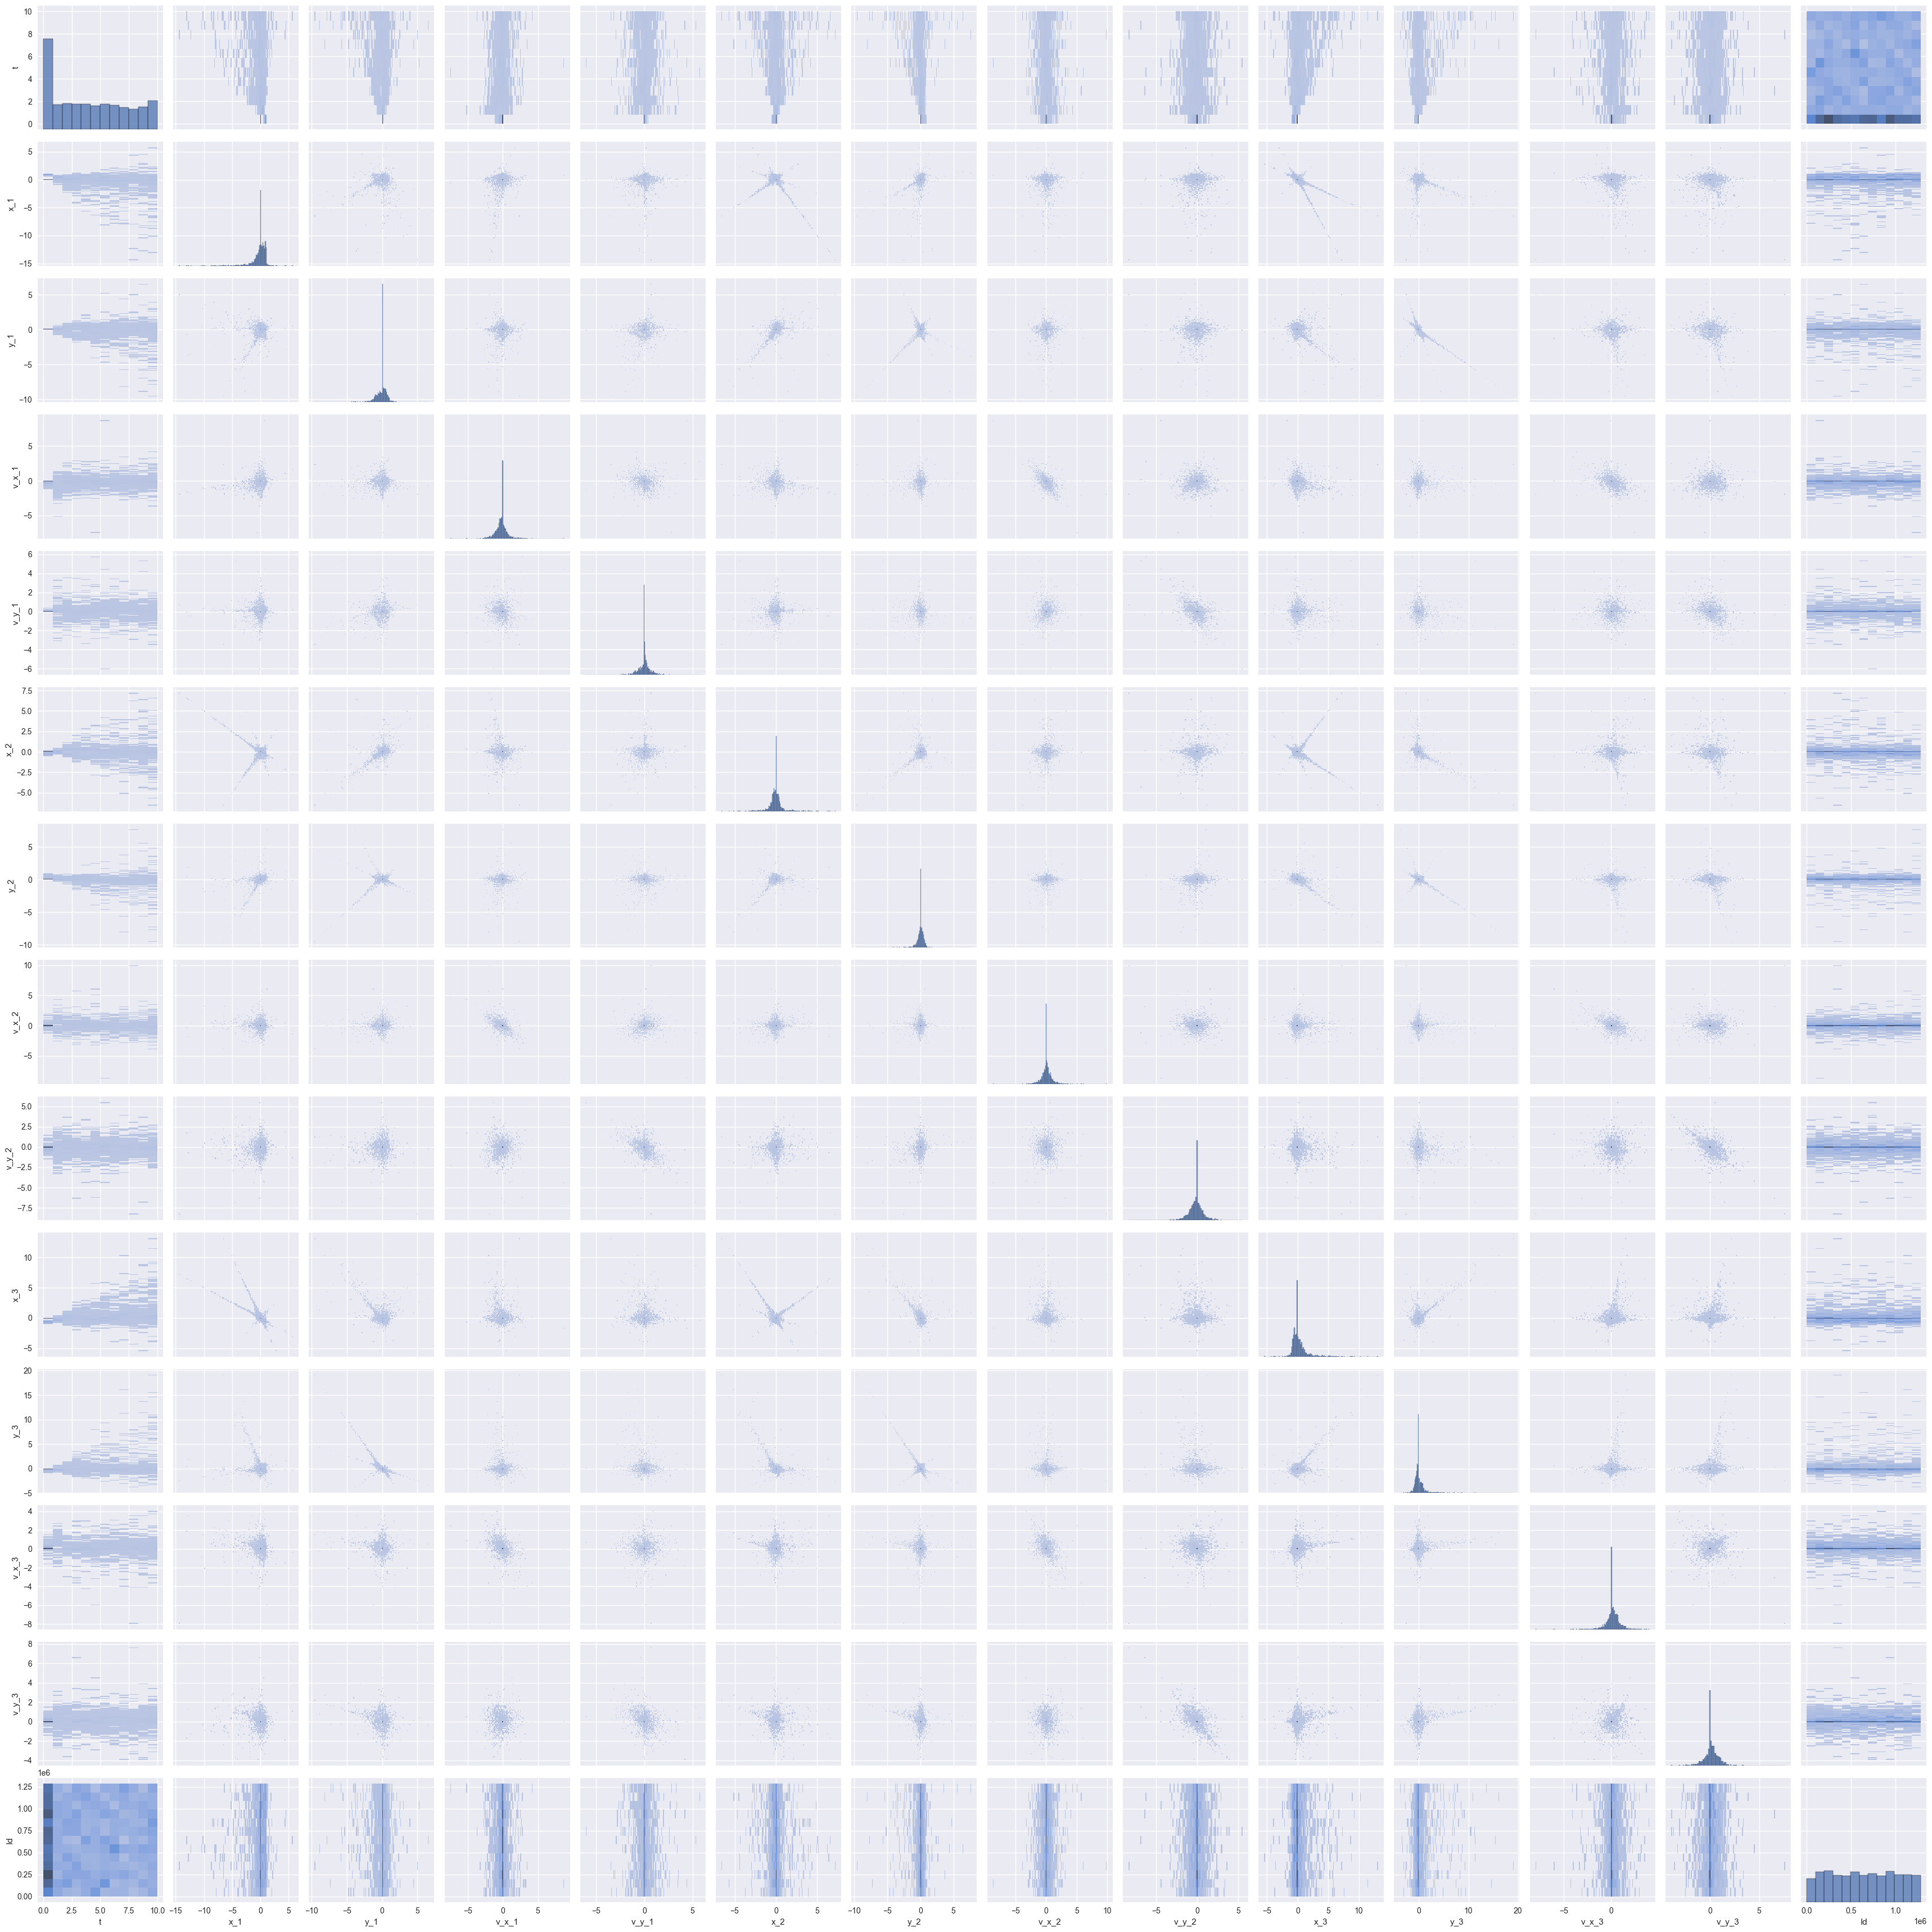

In [18]:
import seaborn as sns
sns.pairplot(df.sample(2000), kind="hist")

In [17]:
import sys
print(sys.executable)


/opt/homebrew/Cellar/jupyterlab/4.4.2/libexec/bin/python


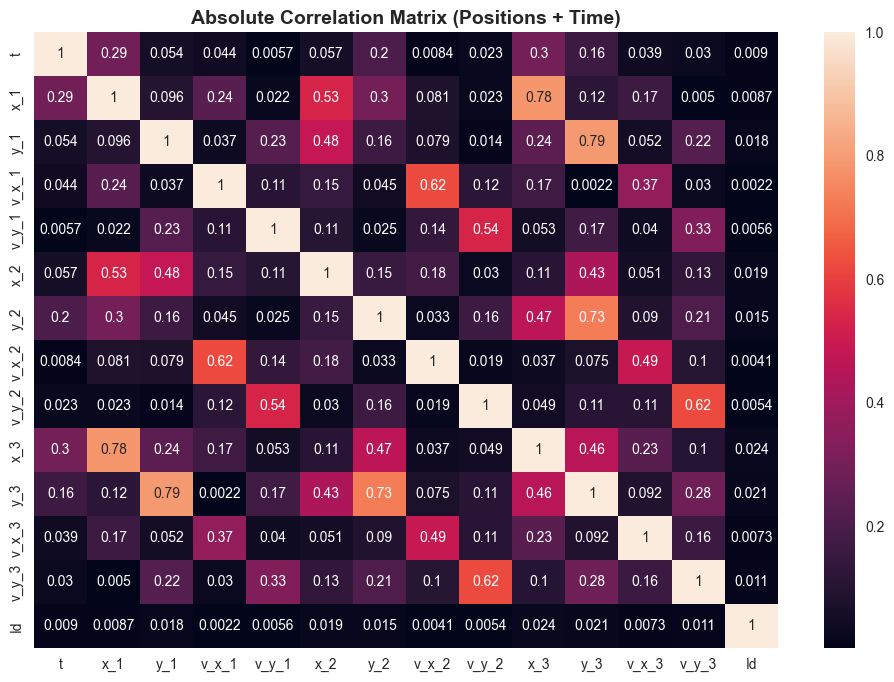

In [19]:
corr = df.corr().abs()
plt.figure(figsize=(12, 8)) 
sns.heatmap(corr, annot=True)
plt.title("Absolute Correlation Matrix (Positions + Time)", fontsize=14, weight='bold')
plt.show()


### Variable Reduction

In [20]:

import numpy as np


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import root_mean_squared_error

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.decomposition import PCA

def _make_regressor(regressor):
    key = str(regressor).lower()
    if key == "linear":
        return LinearRegression()
    if key == "ridgecv":
        # broad alpha grid; change if needed
        return RidgeCV(alphas=np.logspace(-6, 3, 20), cv=5, scoring="neg_mean_squared_error")
    else:
        return LinearRegression()


def validate_poly_regression(X_train, y_train, X_val, y_val,
                             regressor=None, degrees=range(1, 15), max_features=None):
  
    best_rmse = np.inf
    best_model = None

    p = X_train.shape[1]

    for d in degrees:
        steps = []
        poly = PolynomialFeatures(degree=d, include_bias=False)
        steps.append(("poly", poly))
        steps.append(("scaler", StandardScaler()))

 
        if max_features is not None:
            steps.append(("pca", PCA(n_components=max_features)))

        reg = _make_regressor(regressor)
        steps.append(("reg", reg))
        pipe = Pipeline(steps)

  
        pipe.fit(X_train, y_train)

     
        n_out = pipe.named_steps["poly"].n_output_features_
        print(f"[degree={d}] Polynomial features: {n_out}")

    
        y_pred = pipe.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        print(f"[degree={d}] RMSE: {rmse:.6f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_model = pipe

    print(f"\nBest degree = {best_model.named_steps['poly'].degree} with RMSE = {best_rmse:.6f}")
    return best_model, best_rmse

def subsample(X, Y, frac, start_frac=0.0):
    n = len(X)
    k = int(frac * n) - int(frac * n) % 257
    s = int(start_frac * n) - int(start_frac * n) % 257
    return X[s:s+k], Y[s:s+k]

In [2]:
import matplotlib.pyplot as plt
from collections import Counter

def run_degree_stability_tests(X_train, y_train, X_val, y_val,
                               regressor="ridgecv",
                               degrees=range(1, 4),
                               n_runs=10, sample_frac=0.1,
                               max_features=None, plot_path="degree_distribution.pdf"):
    chosen = []

    for r in range(n_runs):
        Xs, Ys = subsample(X_train, y_train, frac=sample_frac, start_frac=r*sample_frac)
        model, rmse = validate_poly_regression(
            Xs, Ys, X_val, y_val,
            regressor=regressor, degrees=degrees, max_features=max_features
        )
        chosen.append(model.named_steps["poly"].degree)
        print(f"[Run {r+1}/{n_runs}] picked degree {chosen[-1]} (RMSE={rmse:.5f})")


    counts = Counter(chosen)
    print("\nSelected degrees counts:", dict(counts))

    plt.figure(figsize=(7,4))
    xs = sorted(counts.keys())
    ys = [counts[x] for x in xs]
    plt.bar(xs, ys)
    plt.xlabel("Selected polynomial degree")
    plt.ylabel("Frequency (out of %d)" % n_runs)
    plt.title("Distribution of Selected Degrees")
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()

 
    best_degree = max(counts.items(), key=lambda kv: (kv[1], -kv[0]))[0]
    print(f"Best (modal) degree over {n_runs} runs: {best_degree}")
    return chosen, best_degree


   Feature 1 Feature 2  Correlation
32       y_1       y_3     0.793226
20       x_1       x_3     0.782191
66       y_2       y_3     0.728914
39     v_x_1     v_x_2     0.624286
79     v_y_2     v_y_3     0.623556
..       ...       ...          ...
80     v_y_2        Id     0.005433
23       x_1     v_y_3     0.004981
75     v_x_2        Id     0.004092
45     v_x_1        Id     0.002233
42     v_x_1       y_3     0.002227

[91 rows x 3 columns]
[Baseline] Val RMSE: 1.4572


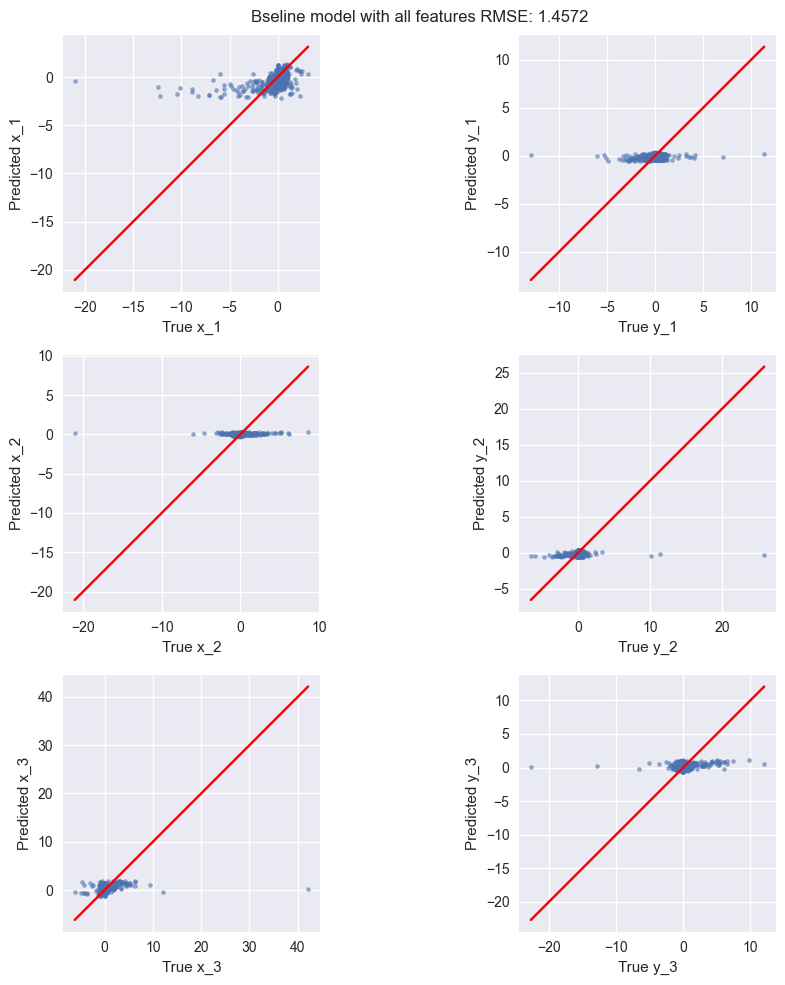

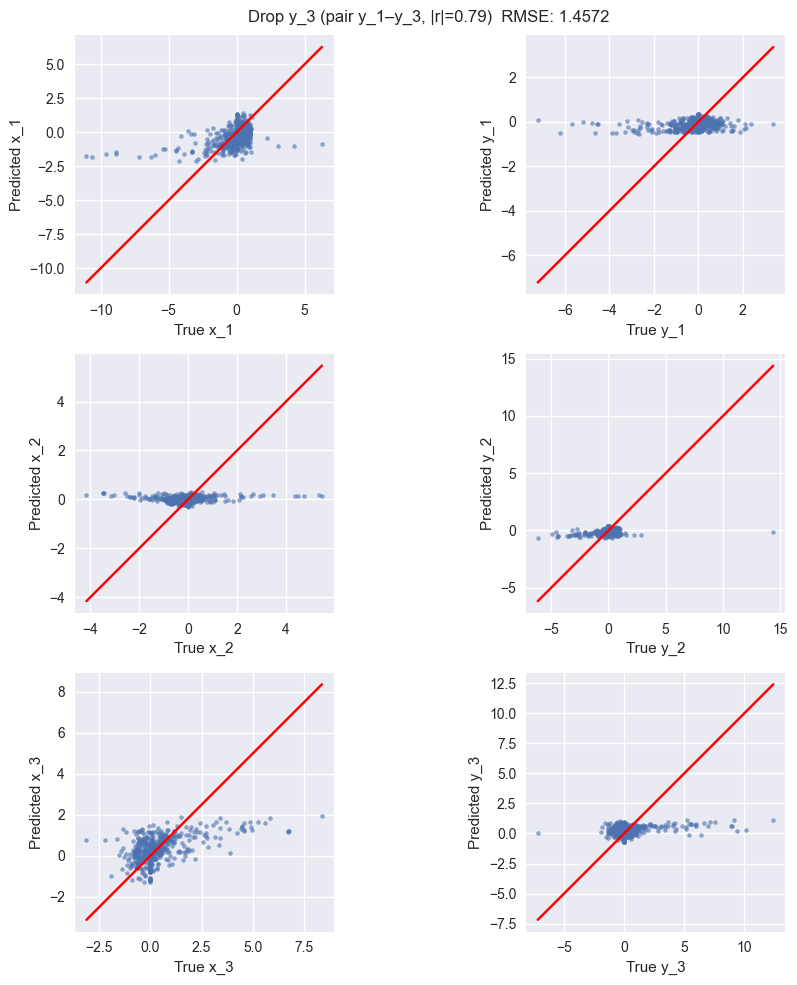

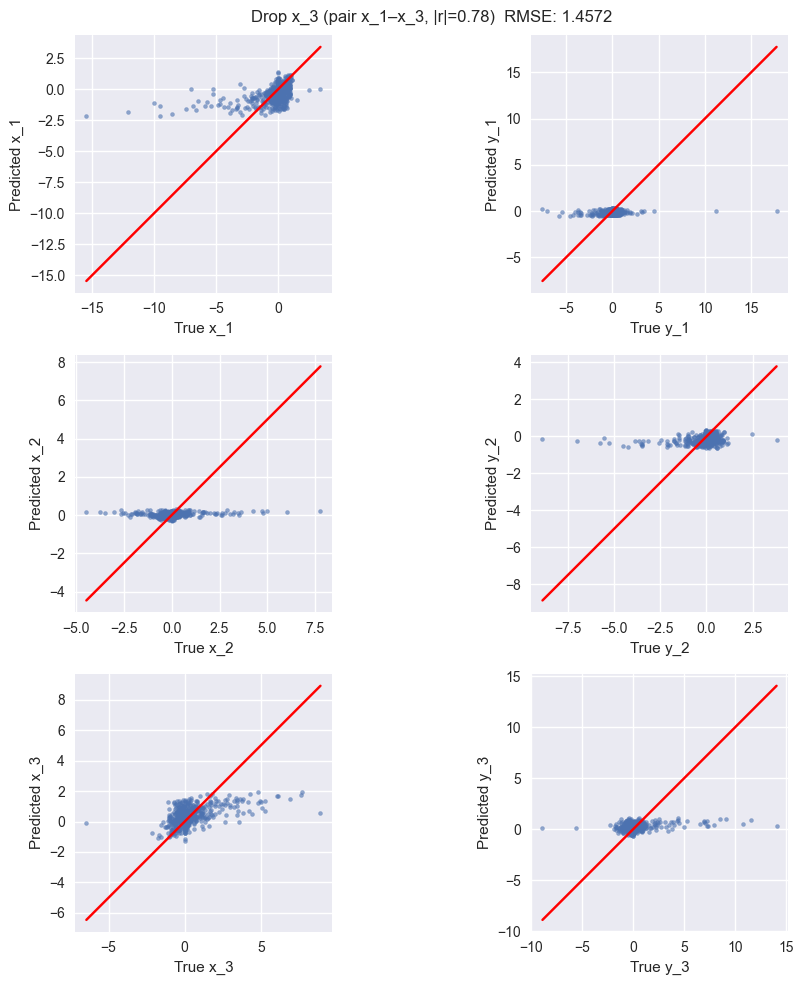

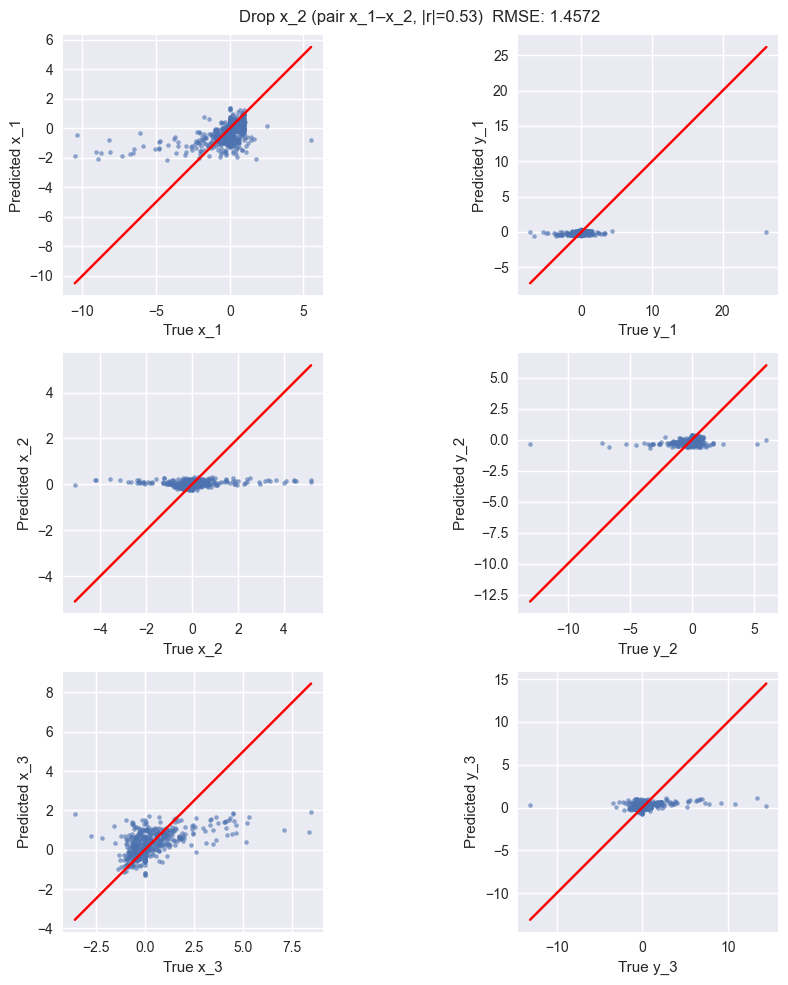

break
[{'drop': 'y_3', 'paired_with': 'y_1', 'abs_corr': 0.7932262027734588, 'rmse': 1.4572493232451116}, {'drop': 'x_3', 'paired_with': 'x_1', 'abs_corr': 0.7821914759570795, 'rmse': 1.4572493232451114}, {'drop': 'x_2', 'paired_with': 'x_1', 'abs_corr': 0.5331592019379877, 'rmse': 1.4572493232451116}]
Kept features: ['x_1', 'y_1', 'y_2', 't']


,drop,paired_with,abs_corr,rmse
0,y_3,y_1,0.793226,1.457249
1,x_3,x_1,0.782191,1.457249
2,x_2,x_1,0.533159,1.457249


In [22]:

from sklearn.pipeline import Pipeline

features = ["x_1", "y_1", "x_2", "y_2", "x_3", "y_3", "t"]
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Flatten & sort pairs
corr_pairs = (upper.stack().reset_index().rename(columns={"level_0":"Feature 1","level_1":"Feature 2",0:"Correlation"}).sort_values(by="Correlation", ascending=False))
print(corr_pairs)

base_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("linear", LinearRegression())
])

base_model =base_pipeline.fit(X_train, Y_train)
y_val_pred_base = baseline.predict(X_val)
rmse_base = root_mean_squared_error(Y_val, y_val_pred_base)
print(f"[Baseline] Val RMSE: {rmse_base:.4f}")
# y–ŷ plot 
plot_y_yhat(Y_val, y_val_pred_base, plot_title=f"Bseline model with all features RMSE: {rmse_base:.4f}")

THRESHOLD = 0.4  
log_rows = []
feat_to_idx = {f: i for i, f in enumerate(features)}
kept = features.copy()
current_rmse = rmse_base
current_model = base_model

for f1, f2, r in corr_pairs.itertuples(index=False, name=None):  # feature_1, feature_2, abs_corr
    if r < THRESHOLD:
        print("break")
        break
    if f1 not in kept or f2 not in kept:
        continue

    trial_feats = [f for f in kept if f != f2]
    cols = [feat_to_idx[f] for f in trial_feats]
    X_trial_tr = X_train[:, cols]
    X_trial_va = X_val[:, cols]

    trial_model = base_pipeline.fit(X_trial_tr, Y_train)
    trial_val = base_pipeline.predict(X_trial_va)
    trial_rmse = root_mean_squared_error(Y_val, trial_val)
    plot_y_yhat(Y_val, trial_val, plot_title=f"Drop {f2} (pair {f1}–{f2}, |r|={r:.2f})  RMSE: {trial_rmse:.4f}")

    log_rows.append({"drop": f2, "paired_with": f1, "abs_corr": r, "rmse": trial_rmse})

 
    if trial_rmse <= current_rmse * 1.002:  # 0.2% tolerance
        kept = trial_feats
        current_rmse = trial_rmse
        current_model = trial_model
print(log_rows)
elimination_log = pd.DataFrame(log_rows).sort_values(["abs_corr"], ascending=False)
print("Kept features:", kept)
display(elimination_log)


[degree=1] Polynomial features: 4
[degree=1] RMSE: 1.460502
[degree=2] Polynomial features: 14
[degree=2] RMSE: 1.429146
[degree=3] Polynomial features: 34
[degree=3] RMSE: 1.394660
[degree=4] Polynomial features: 69
[degree=4] RMSE: 1.364675
[degree=5] Polynomial features: 125
[degree=5] RMSE: 1.342983
[degree=6] Polynomial features: 209
[degree=6] RMSE: 1.344569
[degree=7] Polynomial features: 329
[degree=7] RMSE: 1.352338
[degree=8] Polynomial features: 494
[degree=8] RMSE: 1.346322

Best degree = 5 with RMSE = 1.342983
[Run 1/10] picked degree 5 (RMSE=1.34298)
[degree=1] Polynomial features: 4
[degree=1] RMSE: 1.462385
[degree=2] Polynomial features: 14
[degree=2] RMSE: 1.433644
[degree=3] Polynomial features: 34
[degree=3] RMSE: 1.406288
[degree=4] Polynomial features: 69
[degree=4] RMSE: 1.393688
[degree=5] Polynomial features: 125
[degree=5] RMSE: 1.411514
[degree=6] Polynomial features: 209
[degree=6] RMSE: 1.424167
[degree=7] Polynomial features: 329
[degree=7] RMSE: 1.458110


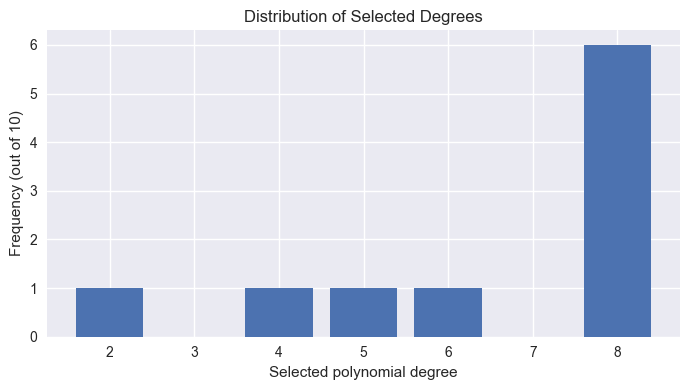

Best (modal) degree over 10 runs: 8


/opt/homebrew/Cellar/jupyterlab/4.4.2/libexec/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.18622e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[Poly] Val RMSE: 1.254324


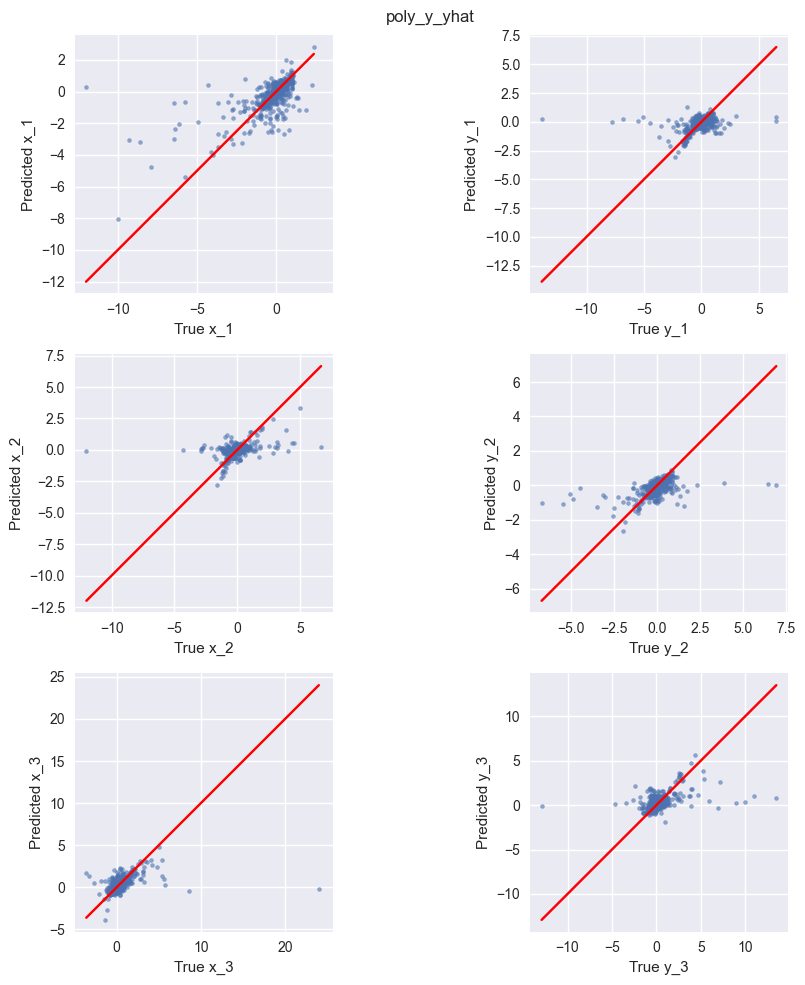

In [23]:
feat_to_idx = {f: i for i, f in enumerate(features)}
cols = [feat_to_idx[f] for f in kept]  


X_train_dropped_features = X_train[:, cols]
X_val_dropped_features = X_val[:, cols]


chosen_degrees, degree_mode = run_degree_stability_tests(
    X_train_dropped_features, Y_train, X_val_dropped_features, Y_val,
    regressor="ridgecv", degrees=range(1, 9),
    n_runs=10, sample_frac=0.05, max_features=None,
    plot_path="degree_distribution_reduced.pdf"
)

best_degree = degree_mode   
final_poly_reduced = Pipeline([
    ("poly", PolynomialFeatures(degree=best_degree, include_bias=False)),
    ("scaler", StandardScaler()),
    ("reg", _make_regressor("ridgecv"))
]).fit(X_train_dropped_features, Y_train)


y_val_pred_poly = final_poly_reduced.predict(X_val_dropped_features)
rmse_poly = root_mean_squared_error(Y_val, y_val_pred_poly)
print(f"[Poly] Val RMSE: {rmse_poly:.6f}")
plot_y_yhat(Y_val, y_val_pred_poly, plot_title="poly_y_yhat")

In [24]:
# Build features for Kaggle test set
X_kaggle_df = pd.read_csv("data/X_test.csv") 
X_kaggle = build_init2t_X(X_kaggle_df, L=257)
X_kaggle_dropped_features = X_kaggle[:, cols]  

Y_kaggle_pred = final_poly_reduced.predict(X_kaggle_dropped_features)    
submission = pd.DataFrame(Y_kaggle_pred, columns=["x_1","y_1","x_2","y_2","x_3","y_3"])

submission.insert(0, "Id", np.arange(len(submission)))

submission.to_csv("reduced_polynomial_submission.csv", index=False)
print("Wrote reduced polynomial_submission.csv")

Wrote reduced polynomial_submission.csv


### Adding variables

In [25]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import root_mean_squared_error

def _make_regressor(regressor):
    if regressor is None or regressor == "linear":
        return LinearRegression()
    if regressor == "ridgecv":
        return RidgeCV(alphas=np.logspace(-6, 6, 40),  
                       cv=5, scoring="neg_mean_squared_error")
    return regressor


def _pairwise_diffs_np(X):
    """
    X: columns [t, x1, y1, x2, y2, x3, y3]
    Returns [dx12, dy12, dx13, dy13, dx23, dy23]
    """
    X = np.asarray(X)
    _, x1, y1, x2, y2, x3, y3 = [X[:, i] for i in range(7)]
    dx12, dy12 = x1 - x2, y1 - y2
    dx13, dy13 = x1 - x3, y1 - y3
    dx23, dy23 = x2 - x3, y2 - y3
    return np.column_stack([dx12, dy12, dx13, dy13, dx23, dy23])

def make_pairdiffs_transformer():
    names = np.array(["dx12","dy12","dx13","dy13","dx23","dy23"], dtype=object)
    return FunctionTransformer(
        func=lambda X: _pairwise_diffs_np(X),
        feature_names_out=lambda est, names_in=None: names
    )

def validate_poly_regression_diffsplus(
        X_train, y_train, X_val, y_val,
        regressor="ridgecv",
        degrees=(1, 2),          
        poly_on_diffs=True,      
        poly_on_raw=False,       
        max_features=None
    ):

    best_rmse, best_model = np.inf, None
    n_in = X_train.shape[1]
    assert n_in == 7, f"Expected 7 columns [t,x1,y1,x2,y2,x3,y3], got {n_in}"

    diffs_tf = make_pairdiffs_transformer()

    for d in degrees:
        transformers = []

  
        if poly_on_raw:
            transformers.append((
                "raw_poly",
                Pipeline([("poly", PolynomialFeatures(degree=d, include_bias=False))]),
                list(range(n_in))
            ))
        else:
            transformers.append(("raw_linear", "passthrough", list(range(n_in))))

        
        if poly_on_diffs:
            transformers.append((
                "diffs_poly",
                Pipeline([
                    ("diffs", diffs_tf),
                    ("poly", PolynomialFeatures(degree=d, include_bias=False)),
                ]),
                list(range(n_in))
            ))
        else:
            transformers.append(("diffs_linear", diffs_tf, list(range(n_in))))

        ct = ColumnTransformer(transformers, remainder="drop", sparse_threshold=0.0)

        steps = [("features", ct), ("scaler", StandardScaler())]
        if max_features is not None:
            steps.append(("pca", PCA(n_components=max_features)))
        steps.append(("reg", _make_regressor(regressor)))

        pipe = Pipeline(steps)


        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)

      
        n_out = pipe.named_steps["features"].transform(X_train[:5]).shape[1]
        label = f"[deg={d} | poly_raw={'Y' if poly_on_raw else 'N'} | poly_diffs={'Y' if poly_on_diffs else 'N'}]"
        print(f"{label}  features_out={n_out}  RMSE={rmse:.6f}")

        if rmse < best_rmse:
            best_rmse, best_model = rmse, pipe

    print(f"\nBest (raw + pairwise diffs) RMSE = {best_rmse:.6f}")
    return best_model, best_rmse

X_train_sub , Y_train_sub = subsample(X_train, Y_train, frac=0.5)
# X_val_sub   , Y_val_sub   = subsample(X_val,   Y_val,   frac=0.1)


poly_model_diffs, rmse_diffs = validate_poly_regression_diffsplus(
    X_train_sub, Y_train_sub, X_val, Y_val,
    regressor="ridgecv",
    degrees=(1, 2, 3),       
    poly_on_diffs=True,         
    poly_on_raw=False,          
    max_features=None
)

[deg=1 | poly_raw=N | poly_diffs=Y]  features_out=13  RMSE=1.458914
[deg=2 | poly_raw=N | poly_diffs=Y]  features_out=34  RMSE=1.449172
[deg=3 | poly_raw=N | poly_diffs=Y]  features_out=90  RMSE=1.425088

Best (raw + pairwise diffs) RMSE = 1.425088


## Task 4

In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

def validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1, 15)):
  
    timings = []
    best_rmse = np.inf
    best_k = None
    best_model = None

    for kk in k:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsRegressor(n_neighbors=int(kk),
                                        weights="distance",   
                                        metric="euclidean", p=2))
        ])

        t0 = time.perf_counter()
        pipe.fit(X_train, y_train)
        fit_time = time.perf_counter() - t0

        t1 = time.perf_counter()
        y_hat = pipe.predict(X_val)
        pred_time = time.perf_counter() - t1

        rmse = root_mean_squared_error(y_val, y_hat)

        timings.append({"k": int(kk), "rmse": rmse,
                        "fit_time_s": fit_time, "predict_time_s": pred_time})

        if rmse < best_rmse:
            best_rmse = rmse
            best_k = int(kk)
            best_model = pipe

        print(f"k={kk:2d} | RMSE={rmse:.6f} | fit={fit_time:.4f}s | predict={pred_time:.4f}s")

    results = pd.DataFrame(timings).sort_values("k").reset_index(drop=True)
    print(f"\nBest k = {best_k} with RMSE = {best_rmse:.6f}")
    return best_model, best_k, best_rmse, results



def plot_knn_results(results, title_prefix="kNN validation"):
    """Plot RMSE and timings vs k for your slides."""
    k = results["k"].to_numpy()
    rmse = results["rmse"].to_numpy()
    fit_t = results["fit_time_s"].to_numpy()
    pred_t = results["predict_time_s"].to_numpy()


    plt.figure(figsize=(5,4))
    plt.plot(k, rmse, marker="o")
    plt.xlabel("k (n_neighbors)")
    plt.ylabel("RMSE")
    plt.title(f"{title_prefix}: RMSE vs k")
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(5,4))
    plt.plot(k, pred_t, marker="o")
    plt.xlabel("k (n_neighbors)")
    plt.ylabel("Predict time (s)")
    plt.title(f"{title_prefix}: predict time vs k")
    plt.tight_layout()
    plt.show()

   
    plt.figure(figsize=(5,4))
    plt.plot(k, fit_t, marker="o")
    plt.xlabel("k (n_neighbors)")
    plt.ylabel("Fit time (s)")
    plt.title(f"{title_prefix}: fit time vs k")
    plt.tight_layout()
    plt.show()


def plot_yyhat(y_true, y_pred, title="kNN: y vs ŷ (validation)"):
    y_t = np.asarray(y_true).reshape(len(y_true), -1)
    y_p = np.asarray(y_pred).reshape(len(y_pred), -1)
    plt.figure(figsize=(5,5))
    plt.scatter(y_t.ravel(), y_p.ravel(), s=6, alpha=0.4)
    lo, hi = min(y_t.min(), y_p.min()), max(y_t.max(), y_p.max())
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("y (true)")
    plt.ylabel("ŷ (pred)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


k= 1 | RMSE=1.309646 | fit=0.4833s | predict=4.6090s
k= 2 | RMSE=1.298278 | fit=0.4345s | predict=4.6938s
k= 3 | RMSE=1.297809 | fit=0.4296s | predict=4.7266s
k= 4 | RMSE=1.269908 | fit=0.4298s | predict=4.9896s
k= 5 | RMSE=1.256403 | fit=0.4302s | predict=4.9479s
k= 6 | RMSE=1.233271 | fit=0.4317s | predict=5.1147s
k= 7 | RMSE=1.228161 | fit=0.4312s | predict=5.2111s
k= 8 | RMSE=1.218597 | fit=0.4320s | predict=5.3943s
k= 9 | RMSE=1.206279 | fit=0.4306s | predict=5.5615s
k=10 | RMSE=1.191360 | fit=0.5261s | predict=5.8190s
k=11 | RMSE=1.186185 | fit=0.4387s | predict=5.7550s
k=12 | RMSE=1.178131 | fit=0.4314s | predict=5.9299s
k=13 | RMSE=1.168558 | fit=0.4434s | predict=6.0711s
k=14 | RMSE=1.159924 | fit=0.4320s | predict=6.2046s
k=15 | RMSE=1.152141 | fit=0.4507s | predict=6.5061s
k=16 | RMSE=1.143914 | fit=0.4583s | predict=6.7505s
k=17 | RMSE=1.134200 | fit=0.4564s | predict=6.6368s
k=18 | RMSE=1.128169 | fit=0.4452s | predict=6.8315s
k=19 | RMSE=1.124614 | fit=0.4426s | predict=6

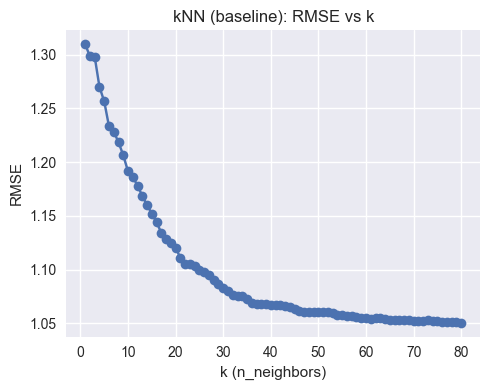

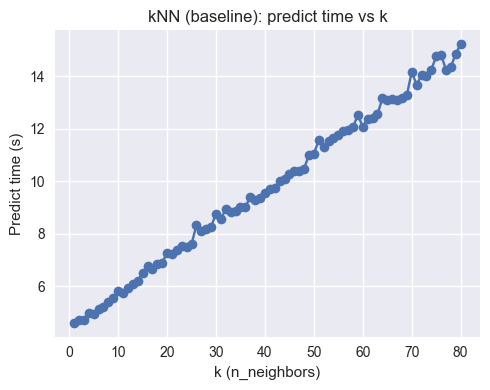

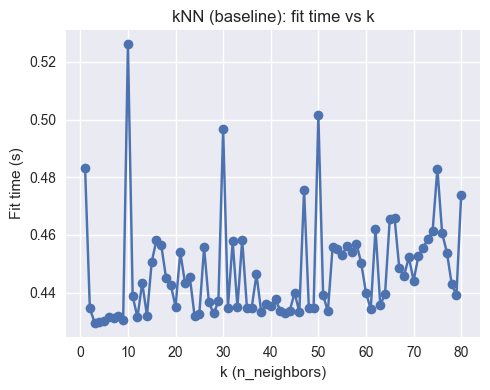

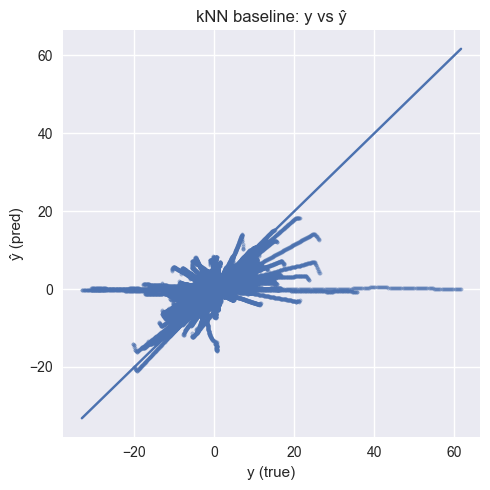

In [27]:

# 1) Baseline
best_b, k_b, rmse_b, res_b = validate_knn_regression(
    X_train, Y_train, X_val, Y_val, k=range(1, 81)
)
plot_knn_results(res_b, title_prefix="kNN (baseline)")
plot_yyhat(Y_val, best_b.predict(X_val), title="kNN baseline: y vs ŷ")


In [28]:
# Kaggle submission for knn
X_kaggle_df = pd.read_csv("data/X_test.csv")    
X_kaggle = build_init2t_X(X_kaggle_df, L=257)   
Y_kaggle_pred = best_b.predict(X_kaggle)        
submission = pd.DataFrame(Y_kaggle_pred, columns=["x_1","y_1","x_2","y_2","x_3","y_3"])
submission.insert(0, "Id", np.arange(len(submission)))
submission.to_csv("knn_baseline_submission.csv", index=False)
print("Wrote knn_baseline_submission.csv")

Wrote knn_baseline_submission.csv
